**Author: Meeshawn Marathe**

# Motivation

The world of Artificial Intelligence has witnessed an unprecedented rise in capabilities of machines that continue to narrow the intellectual gap between humans and itself. In particular, *Transformers* have caught the ***"attention"*** of the AI Community especially the Deep Leaning NLP community through its revolutionary *Self-Attention* mechanism by leveraging the multitude of data available across the internet and its parallelization abilities to perform better at Natural Language Understanding and Natural Language Generation than other inductively-biased modern methods like RNN, LSTM, GRU or other sequential models.

Shortly after, a few brilliant minds started visualizing and extending the idea of *Self-attention* mechanism to the field of Computer vision to capture the spatial coherency within an image to improvise upon the existing computer vision tasks like object classification/detection and coined the term ***"Vision Transformers"***. Literature suggests Vision Transfomer are excelling at these tasks compared to other state-of-the-art models, such as ResNet50 with data abundance.

In this work, we attempt to understand, estimate and evaluate the inner working of Vision Transfomers through an Image Classification task performed on MNIST dataset.

# Introduction

In principle, Vision Transformers extend the idea of sentence tokens to images by splitting them into fixed-size patches, each of which are then linearly embedded into a dense vector reprentation along with positional embeddings, with the resulting sequence of vectors being then fed to a standard Transformer encoder. For the classification task at hand, an additional learnable ***“classification token”*** is added to the sequence which will then be used to train a Multi-Layer Perceptron model with a single layer to classify the images into 'k' classes.

Taking a deeper dive into the Encoder architecture reveals the inner working of a traditional Encoder from Transformers (*Vaswani et all, 2017*), which comprises of expanding the individual token(sub-image) embedding vector further into Query (Q), Key(K) and Value(V) vectors through learnable parameters (Wq, Wk, Wv) and finding the similarity between multi-headed (Q,K,V) triplets. By doing this every token is attending to every other tokens with an objective to learn the spatial coherency embedded in the image. The number of heads is a model hyperparameter, where the size of the image should be an integer multiple of the heads. Normalization and residual connection are made at multiple locations to stabalize the learnable weights  and aid the model to overcome vanishing gradients during training process. While the above mentioned operations constitute for one encoder block, typically, it is essential to cascade a sizeable number of such blocks to increase the complexity of the network owing to the nature of data for more efficient and robust learning. 

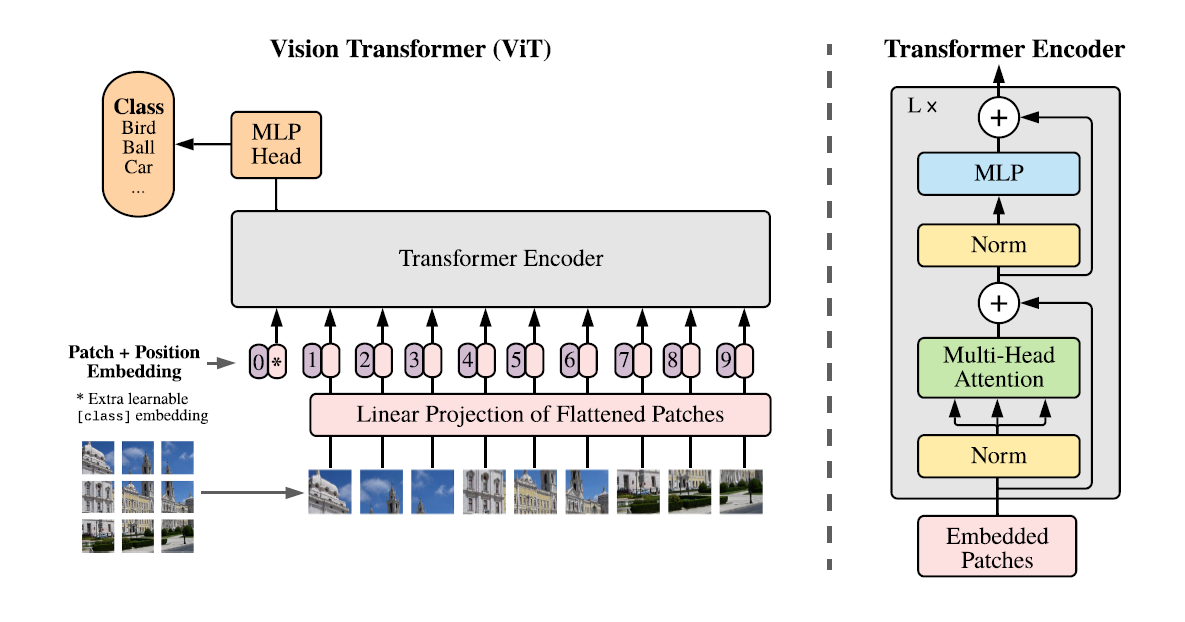

In [1]:
from IPython.display import Image
Image("vit.png")

**Source: Dosovitskiy et al., 2020**

# Methodology

We will now walk through the steps of formulating the task of Handwritten digits (MNIST) classification into a sequential, "many-to-one" learning task with the help of an encoder architecture which is borrowed from Transformers:

- **Step 1:** Each and every input image **(28x28)** is split into a series of subimages, known as *patches* **(49x4x4)**, which are square matrices of reduced order dimensions, flattened into a 1D vector **(49x16)** and then finally projected to a reduced order 'D' dimensional vector **(49x8)** with the help of a trainable linear projection. The final output of this projection is termed *patch-embeddings*.


- **Step 2:** A classification token embedding, same size as that of the patch-embeddings, is concatenated to the patch embeddings **(50x8)** as the first token embedding in the sequence, which will later be passed through a classification head (implemented with an MLP) to predict object classes.


- **Step 3:** Standard 1-D positional embeddings, as proposed in Vaswani et all (2017), is used as is in this model to retain positional information of the patches. These positional embeddings are directly added to the patch embeddings from **Step 1**. Before proceeding to the next block, Layer Normalization is performed on the final output of this addition. Layer normalization assists the gradient descent process of updating the weights since the distribution being scaled, allows for the weights to assume scaled values that are not orders of magnitude apart from one another.


- **Step 4:** Every individual patch embedding **(50x8)** is projected onto 3 different projection vectors, namely Query (Q), Key (K) and Value (V) , of same size as the original patch embedding with the help of 3 learnable projection matrices $W_q$ **(8x8)**, $W_k$ **(8x8)**, and $W_v$ **(8x8)** respectively. The 3 projections are further split into mutliple heads (here, # heads = 2), each of size **(50x4)** , and the similarity between tokens is computed by multiplying the query head of one token and the key head of every other token. The output of this operation **(50x4 \* 4x50 = 50x50)** is passed through a softmax layer to introduce non-linearity and finally mulitplied with the value head **(50x4)** to give back a **(50x4)** matrix. Similar operation will be performed for all the other heads (in our case the 2nd head), to generate another **(50x4)** matrix. The ouputs from all the heads are then concatenated to give back a matrix whose size matches with the original patch embeddings **(50x8)**. This entire step is termed **Multi-headed Self Attention (MSA)**.


- **Step 5:** The output from **Step 3**, before performing Layer Normalization, is now added to the output from **Step 4**, i.e. after performing MSA, as a residual connection in order to better stabilize the weights of the network and help circumvent the vanishing gradient problem.


- **Step 6:** Layer Normalization is performed once again before being finally fed to the classification head. Here, a Multi-Layer Perceptron model, composed of two hidden layers, is implemented to realize the task of digit recognition. The input to the classification head is the learned class token **(1x8)**

- **Step 7:** Steps 4 - 6 constitute one block of the encoder architecture. Like this, several encoder blocks can be cascaded together to increase the complexity of the model.

# Implementation Details

1. In order to obtain a robust ViT architecture, **Model Selection** has been performed for the classification task at hand in a 2D space of hyperparameters. In particular, model selection has been performed across the following set of hyperparameters using **3-fold cross validation** for each model configuration:

    - **Number of Encoder Blocks**: [2,3]
    - **Number of Hidden Units (MLP 1st Layer):** [16, 32]


2. Fixed Hyperparameters:

    - **Learning Rate:** 0.005
    - **Number of Training Epochs:** 5
    - **Number of MLP Hidden Layers:** 2


3. The handwritten digit recognition task at hand has been modeled as a class **MNISTViT** along with other helper classes such as **ViT**, **ViTBlock**, **MSA** described as follows:

    - **MNISTViT**: This is the main class which encapsulates member methods such as:
        + **modelSelection():** Iterates through 4 different network hypotheses as described earlier and selects the best model model based on the average Misclassification error (over 3-folds) of the validation set.
        + **compileModel():** This function configures the network parameters based on the assigned set of hyperparameters during model selection.
        + **fit():** This function iteratively perfoms backpropagation and gradient descent to update the network weights over 5 epochs. It also records training proxy and misclassifcation errors.
        + **computeLoss():** This function computes the misclassification and proxy error losses for every learned hypothesis evaluated on the validation set.
        + **plotHistory():** This function plots the results of model selection and highlights the best model hyperparameter set.
        + **evaluate():** This function uses the best model selected by **modelSelection()** to train on the entire training set and evaluates against the test set. It also records and displays the proxy and misclassification losses for every epoch during the training and test phases.
     
    - **ViT:** This is a helper class to the main **MNISTViT** class that defines a framework for the Transformer Encoder Architecture and preprocesses the images (**createSubImages()** method) to create sub images that are fed as tokens to the encoder block. This block, in turn, makes use of two helper classes that are described below:
    
        + **ViTBlock:** This class serves as the atomic unit of the encoder architecture implementation, which enables multiple encoder blocks to be cascaded in sequence. This class also implements the classfication head which is a two layer MLP model.
        + **MSA:** The main crux of the self-attention mechanism is implemented in this class with the help of Query, Key and Value embeddings. This attention block is appended with MLP head in **ViTBlock** along with multi stage Layer Normalization and residual connections.

# Source Code

In [2]:
# -*- coding: utf-8 -*-
"""
Vision Transformer based Image Classification
@author: Meeshawn Marathe
"""

import numpy as np
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, SubsetRandomSampler

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

np.random.seed(0)
torch.manual_seed(0)

#%%
class ViT(nn.Module):
  # def __init__(self, L, HUratio, n_blocks, origImgDim=(1,28,28), subImageDim=7, hidden_d=8, n_heads=2, out_d=10):
  def __init__(self, HUratio, n_blocks, origImgDim=(1,28,28), subImageDim=7, hidden_d=8, n_heads=2, out_d=10):    
    super(ViT, self).__init__()
    self.origImgDim = origImgDim
    self.subImageDim = subImageDim
    
    self.patch_size = (self.origImgDim[1] / self.subImageDim, self.origImgDim[2] / self.subImageDim)
    
    # Mapping to a lower dimensional embedding
    input_d = int(self.origImgDim[0] * self.patch_size[0] * self.patch_size[1])
    self.embedding = nn.Linear(input_d, hidden_d)
    
    # Learnable classifiation token
    self.class_token = nn.Parameter(torch.rand(1, hidden_d))
    
    # Positional embedding
    posEmbedding = torch.ones(self.subImageDim**2 + 1, hidden_d)
    for i in range(posEmbedding.shape[0]):
        for j in range(hidden_d):
            posEmbedding[i][j] = np.sin(i / (10000 ** (j / hidden_d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / hidden_d)))
    
    # posEmbedding = nn.Parameter(torch.tensor(posEmbedding))
    # posEmbedding.requires_grad = False
    self.register_buffer('posEmbedding', posEmbedding, persistent=False)
    
    # Create additional Encoder blocks
    # self.blocks = nn.ModuleList([ViTBlock(hidden_d, HUratio, n_heads, L=L) for _ in range(n_blocks)])
    self.blocks = nn.ModuleList([ViTBlock(hidden_d, HUratio, n_heads) for _ in range(n_blocks)])
    
    # Create a dense network for the classification task
    self.mlp = nn.Sequential(nn.Linear(hidden_d, out_d),nn.Softmax(dim=-1))
    
    
  def createSubImages(self, images):
    m, channel, height, width = images.shape

    assert height == width, "createSubImages method is implemented for square images only"

    subImages = torch.zeros(m, self.subImageDim ** 2, height * width * channel // self.subImageDim ** 2)
    subImgSize = height // self.subImageDim # 4

    for idx, image in enumerate(images):
        for i in range(self.subImageDim):
            for j in range(self.subImageDim):
                subImage = image[:, i * subImgSize: (i + 1) * subImgSize, j * subImgSize: (j + 1) * subImgSize]
                subImages[idx, i * self.subImageDim + j] = subImage.flatten()
    return subImages

  def forward(self, images):
    m, channel, height, width = images.shape
    subImages = self.createSubImages(images).to(self.posEmbedding.device)
    subImages = self.embedding(subImages)
    # Appending classification embedding to along with the sub-image embeddings 
    # for every image
    subImages = torch.cat((self.class_token.expand(m, 1, -1), subImages), dim=1)
    
    # Adding positional embeddings
    out = subImages + self.posEmbedding.repeat(m, 1, 1)
    
    # Transformer Blocks
    for block in self.blocks:
        out = block(out)
        
     # Extracting the classification token only
    out = out[:, 0]
    
    # Return the classification prediction
    return self.mlp(out)
 
#%%
class ViTBlock(nn.Module):
    # def __init__(self, hidden_d, HUratio, n_heads, L):
    def __init__(self, hidden_d, HUratio, n_heads):
        super(ViTBlock, self).__init__()        
        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)     
                
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, HUratio * hidden_d),
            nn.GELU(),
            nn.Linear(HUratio * hidden_d, hidden_d)
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out 
 
#%%
class MSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        d_head = int(d / n_heads) # 4
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head # 4
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])  
   
#%%  
class MNISTViT:
  def __init__(self, num_epochs):
    self.num_epochs = num_epochs
    self.nFolds = 3
    # self.alphaModelSelection = [0.001, 0.003, 0.01, 0.03]
    # self.numEncoderBlocks = [1, 2, 3]
    # self.numHiddenLayersMLP = [1, 2]
    self.alphaModelSelection = [0.005]
    self.numEncoderBlocks = [2,3]
    self.numHiddenUnitsRatio = [2,4]
    self.bestModelParams = None
    
    self.trainOrig = MNIST(root='./datasets', train=True, download=True, transform=ToTensor())
    self.testOrig = MNIST(root='./datasets', train=False, download=True, transform=ToTensor())
    # self.train = DataLoader(train, shuffle=True, batch_size=128)
    # self.test = DataLoader(test, shuffle=False, batch_size=128)
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device: ", self.device, f"({torch.cuda.get_device_name(self.device)})" if torch.cuda.is_available() else "")

  def modelSelection(self):
    # 3-fold cross validation across all the possible models based on 
    # various hyperparameters:
    self.trainMisClassifyLoss = {}
    self.testMisClassifyLoss = {} 
    splits = KFold(n_splits=self.nFolds,shuffle=False)
    
    for self.n_blocks in self.numEncoderBlocks:
      # for self.L in self.numHiddenLayersMLP:
      for self.HUratio in self.numHiddenUnitsRatio:
        for self.alpha in self.alphaModelSelection:
          # define losses here
          trainMisClassifyLoss = 0
          testMisClassifyLoss = 0
          for fold, (train_idx, valid_idx) in enumerate(splits.split(self.trainOrig)):
            # Prepare data
            train = SubsetRandomSampler(train_idx)
            valid = SubsetRandomSampler(valid_idx)
            self.train = DataLoader(self.trainOrig, batch_size=128, sampler=train)
            self.test = DataLoader(self.trainOrig, batch_size=128, sampler=valid)
            print("===============================================")
            # print("# Enc blocks = {}, MLP L1 HU = {}, alpha={}, fold-{}" .format(self.n_blocks,self.L,self.alpha, fold+1))            
            # self.compileModel(self.L, self.HUratio)
            self.compileModel()
            print("# Enc blocks = {}, MLP L1 HU = {}, alpha={}, fold-{}" .format(self.n_blocks,self.HUratio*8,self.alpha, fold+1))            

            self.fit()
            self.computeLoss()
            trainMisClassifyLoss += self.trainMisClassifyErr
            testMisClassifyLoss += self.testMisClassifyErr
            
          # idx = "Enc_blocks=" + str(self.n_blocks) + " L=" + str(self.L) + " a=" + str(self.alpha)
          idx = "Enc_blocks=" + str(self.n_blocks) + " HU=" + str(self.HUratio*8) + " a=" + str(self.alpha)
          self.trainMisClassifyLoss[idx] = trainMisClassifyLoss/self.nFolds
          self.testMisClassifyLoss[idx] = testMisClassifyLoss/self.nFolds
          
    bestModel = min(self.testMisClassifyLoss, key=self.testMisClassifyLoss.get)  
    self.bestModelParams = np.array([val.split('=') for val in bestModel.split()])[:,1].astype('double')          

  def plotHistory(self):
    fig, ax = plt.subplots()
    fig.dpi = 300
    trainMisClassifyLoss = list(self.trainMisClassifyLoss.values())
    testMisClassifyLoss = list(self.testMisClassifyLoss.values())
    x = list(self.trainMisClassifyLoss)
    ax.plot(x, trainMisClassifyLoss, 'o-', label="Training")
    ax.plot(x, testMisClassifyLoss, 'o-', label="Validation")
    ax.set_xlabel("Hyperparameters [# Enc blocks, MLP L1 HU, $\\alpha$]", fontweight='bold')
    ax.set_xticklabels(x, rotation=90, fontsize=6)
    ax.set_ylabel("Misclassification Loss", fontweight='bold')
    ax.set_title("Model Selection ({}-fold CV, {} epochs each: \n(Best # Enc blocks*={}, MLP L1 HU*={}, $\\alpha$*= {})" .format(self.nFolds, self.num_epochs, self.bestModelParams[0], self.bestModelParams[1], self.bestModelParams[2]),fontweight='bold')
    ax.legend(loc='lower right')
    ax.plot(np.argmin(np.array(testMisClassifyLoss)), min(testMisClassifyLoss), marker="o", markersize=10, markeredgecolor="red", markerfacecolor="green")
    fig.tight_layout() 
    
    
  # def compileModel(self, L):
  def compileModel(self):
    shape = self.train.dataset.train_data.shape
    # self.model = ViT(L=L, HUratio=self.HUratio, n_blocks=self.n_blocks, origImgDim=(1, shape[1], shape[2]), subImageDim=7, hidden_d=8, n_heads=2, out_d=10).to(self.device)    
    self.model = ViT(HUratio=self.HUratio, n_blocks=self.n_blocks, origImgDim=(1, shape[1], shape[2]), subImageDim=7, hidden_d=8, n_heads=2, out_d=10).to(self.device)    

  def fit(self, cv=True):
    optimizer = Adam(self.model.parameters(), lr=self.alpha)
    self.crossEntropyLoss = CrossEntropyLoss()
    self.trainProxyErr = 0.0
    self.trainMisClassifyErr = 0.0

    self.trainProxyErr_per_epoch = []
    self.trainMisClassifyErr_per_epoch = []
    self.testProxyErr_per_epoch = []
    self.testMisClassifyErr_per_epoch = []    
    for epoch in trange(self.num_epochs, desc="Train"):
        train_loss = 0.0
        inCorrect, total = 0, 0

        for batch in tqdm(self.train, desc=f"Epoch {epoch + 1} in training", position = 0,leave=True):
            x, y = batch
            x, y = x.to(self.device), y.to(self.device)
            y_hat =self.model(x)
            loss = self.crossEntropyLoss(y_hat, y)
            train_loss += loss.detach().cpu().item() / len(self.train)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            inCorrect += torch.sum(torch.argmax(y_hat, dim=1) != y).detach().cpu().item()
            total += len(x)
            
        self.trainProxyErr_per_epoch.append(train_loss)
        self.trainMisClassifyErr_per_epoch.append(inCorrect/total)
        if not cv:
          self.computeLoss()
          self.testProxyErr_per_epoch.append(self.testProxyErr)
          self.testMisClassifyErr_per_epoch.append(self.testMisClassifyErr)
                    
        print(f"Epoch {epoch + 1}/{self.num_epochs} Proxy Train loss: {train_loss:.2f}")
        print(f"Epoch {epoch + 1}/{self.num_epochs} Misclassification Train loss: {inCorrect/total:.2f}")
    self.trainProxyErr = train_loss
    self.trainMisClassifyErr = inCorrect / total 
    
        
  def computeLoss(self):
    with torch.no_grad():
       inCorrect, total = 0, 0
       test_loss = 0.0

       for batch in tqdm(self.test, desc="Testing",position = 0,leave=True):
           x, y = batch
           x, y = x.to(self.device), y.to(self.device)
           y_hat = self.model(x)
           loss = self.crossEntropyLoss(y_hat, y)
           test_loss += loss.detach().cpu().item() / len(self.test)

           inCorrect += torch.sum(torch.argmax(y_hat, dim=1) != y).detach().cpu().item()
           total += len(x)
           
       self.testProxyErr = test_loss
       print(f"Proxy Test loss: {test_loss:.2f}")
       self.testMisClassifyErr = inCorrect / total
       print(f"Misclassification Test Loss: {self.testMisClassifyErr:.2f}")
       
  def evaluate(self):
    self.train = DataLoader(self.trainOrig, shuffle=True, batch_size=128)
    self.test = DataLoader(self.testOrig, shuffle=False, batch_size=128)
    self.n_blocks = int(self.bestModelParams[0])
    self.HUratio = int(self.bestModelParams[1]/8) 
    self.alpha = self.bestModelParams[2]
    self.compileModel()
    print("=========================================================")
    print("Training on the best model parameters:")
    print("# Enc blocks = {}, MLP L1 HU = {}, alpha={}" .format(self.n_blocks,self.HUratio*8,self.alpha))            
    self.fit(cv=False)
    
    # Plot the training results for the best model over the # of training iterations
    fig, ax = plt.subplots()
    fig.dpi = 300     
    ax.plot(np.arange(1,self.num_epochs+1), self.trainMisClassifyErr_per_epoch, 'o-', label="Training")
    ax.plot(np.arange(1,self.num_epochs+1), self.testMisClassifyErr_per_epoch, 'o-', label="Test")
    ax.set_xlabel("Epochs", fontweight='bold')
    ax.set_ylabel("Misclassification Loss", fontweight='bold')
    ax.set_title("Best ViT Model Fit over {} epochs \n(# Enc blocks* = {}, MLP L1 HU* = {}, $\\alpha$* = {}): " .format(self.num_epochs, self.n_blocks, self.HUratio, self.alpha), fontweight='bold')
    ax.legend(loc='upper right')
    fig.tight_layout() 
    
    fig2, ax2 = plt.subplots()
    fig2.dpi = 300
    ax2.plot(np.arange(1,self.num_epochs+1), self.trainProxyErr_per_epoch, 'o-', label="Training")
    ax2.plot(np.arange(1,self.num_epochs+1), self.testProxyErr_per_epoch, 'o-', label="Test")
    ax2.set_xlabel("Epochs", fontweight='bold')
    ax2.set_ylabel("Proxy Loss", fontweight='bold')
    ax2.set_title("Best ViT Model Fit over {} epochs \n(# Enc blocks* = {}, MLP L1 HU* = {}, $\\alpha$* = {}): " .format(self.num_epochs, self.n_blocks, self.HUratio, self.alpha), fontweight='bold')
    ax2.legend(loc='upper right')
    fig2.tight_layout() 

# Results & Discussion

## Results

**Step-1:** Create an object for the **MNISTViT** class

In [3]:
classifier = MNISTViT(num_epochs=5)

Using device:  cuda (NVIDIA GeForce RTX 3050 Ti Laptop GPU)


**Step-2:** Perform Model selection on the set of pre-defined model hyperparameters

In [4]:
classifier.modelSelection()

# Enc blocks = 2, MLP L1 HU = 16, alpha=0.005, fold-1


Train:  20%|███████████████▏                                                            | 1/5 [10:28<41:52, 628.12s/it]

Epoch 1/5 Proxy Train loss: 2.11
Epoch 1/5 Misclassification Train loss: 0.66


Train:  40%|██████████████████████████████▍                                             | 2/5 [21:12<31:53, 637.74s/it]

Epoch 2/5 Proxy Train loss: 1.89
Epoch 2/5 Misclassification Train loss: 0.43


Train:  60%|█████████████████████████████████████████████▌                              | 3/5 [32:17<21:40, 650.10s/it]

Epoch 3/5 Proxy Train loss: 1.83
Epoch 3/5 Misclassification Train loss: 0.36


Train:  80%|████████████████████████████████████████████████████████████▊               | 4/5 [43:41<11:03, 663.44s/it]

Epoch 4/5 Proxy Train loss: 1.79
Epoch 4/5 Misclassification Train loss: 0.33


Train: 100%|████████████████████████████████████████████████████████████████████████████| 5/5 [54:44<00:00, 656.84s/it]


Epoch 5/5 Proxy Train loss: 1.77
Epoch 5/5 Misclassification Train loss: 0.31


Testing: 100%|███████████████████████████████████████████████████████████████████████| 157/157 [03:03<00:00,  1.17s/it]


Proxy Test loss: 1.76
Misclassification Test Loss: 0.30
# Enc blocks = 2, MLP L1 HU = 16, alpha=0.005, fold-2


Train:  20%|███████████████▏                                                            | 1/5 [10:50<43:23, 650.81s/it]

Epoch 1/5 Proxy Train loss: 2.14
Epoch 1/5 Misclassification Train loss: 0.69


Train:  40%|██████████████████████████████▍                                             | 2/5 [21:55<32:56, 658.80s/it]

Epoch 2/5 Proxy Train loss: 1.94
Epoch 2/5 Misclassification Train loss: 0.47


Train:  60%|█████████████████████████████████████████████▌                              | 3/5 [32:25<21:31, 645.91s/it]

Epoch 3/5 Proxy Train loss: 1.87
Epoch 3/5 Misclassification Train loss: 0.41


Train:  80%|████████████████████████████████████████████████████████████▊               | 4/5 [43:08<10:44, 644.66s/it]

Epoch 4/5 Proxy Train loss: 1.82
Epoch 4/5 Misclassification Train loss: 0.36


Train: 100%|████████████████████████████████████████████████████████████████████████████| 5/5 [53:43<00:00, 644.65s/it]


Epoch 5/5 Proxy Train loss: 1.82
Epoch 5/5 Misclassification Train loss: 0.36


Testing: 100%|███████████████████████████████████████████████████████████████████████| 157/157 [03:01<00:00,  1.16s/it]


Proxy Test loss: 1.82
Misclassification Test Loss: 0.36
# Enc blocks = 2, MLP L1 HU = 16, alpha=0.005, fold-3


Train:  20%|███████████████▏                                                            | 1/5 [10:24<41:38, 624.74s/it]

Epoch 1/5 Proxy Train loss: 2.13
Epoch 1/5 Misclassification Train loss: 0.68


Train:  40%|██████████████████████████████▍                                             | 2/5 [20:55<31:25, 628.36s/it]

Epoch 2/5 Proxy Train loss: 1.89
Epoch 2/5 Misclassification Train loss: 0.42


Train:  60%|█████████████████████████████████████████████▌                              | 3/5 [31:36<21:08, 634.21s/it]

Epoch 3/5 Proxy Train loss: 1.79
Epoch 3/5 Misclassification Train loss: 0.33


Train:  80%|████████████████████████████████████████████████████████████▊               | 4/5 [42:14<10:35, 635.47s/it]

Epoch 4/5 Proxy Train loss: 1.75
Epoch 4/5 Misclassification Train loss: 0.29


Train: 100%|████████████████████████████████████████████████████████████████████████████| 5/5 [54:41<00:00, 656.28s/it]


Epoch 5/5 Proxy Train loss: 1.72
Epoch 5/5 Misclassification Train loss: 0.26


Testing: 100%|███████████████████████████████████████████████████████████████████████| 157/157 [03:38<00:00,  1.39s/it]


Proxy Test loss: 1.70
Misclassification Test Loss: 0.24
# Enc blocks = 2, MLP L1 HU = 32, alpha=0.005, fold-1


Train:  20%|███████████████▏                                                            | 1/5 [12:21<49:24, 741.24s/it]

Epoch 1/5 Proxy Train loss: 2.19
Epoch 1/5 Misclassification Train loss: 0.75


Train:  40%|██████████████████████████████▍                                             | 2/5 [26:07<39:34, 791.43s/it]

Epoch 2/5 Proxy Train loss: 2.02
Epoch 2/5 Misclassification Train loss: 0.57


Train:  60%|█████████████████████████████████████████████▌                              | 3/5 [37:12<24:27, 733.66s/it]

Epoch 3/5 Proxy Train loss: 1.86
Epoch 3/5 Misclassification Train loss: 0.40


Train:  80%|████████████████████████████████████████████████████████████▊               | 4/5 [47:07<11:18, 678.91s/it]

Epoch 4/5 Proxy Train loss: 1.79
Epoch 4/5 Misclassification Train loss: 0.33


Train: 100%|████████████████████████████████████████████████████████████████████████████| 5/5 [55:59<00:00, 671.81s/it]


Epoch 5/5 Proxy Train loss: 1.75
Epoch 5/5 Misclassification Train loss: 0.29


Testing: 100%|███████████████████████████████████████████████████████████████████████| 157/157 [02:31<00:00,  1.03it/s]


Proxy Test loss: 1.76
Misclassification Test Loss: 0.30
# Enc blocks = 2, MLP L1 HU = 32, alpha=0.005, fold-2


Train:  20%|███████████████▏                                                            | 1/5 [09:12<36:50, 552.62s/it]

Epoch 1/5 Proxy Train loss: 2.16
Epoch 1/5 Misclassification Train loss: 0.72


Train:  40%|██████████████████████████████▍                                             | 2/5 [17:36<26:11, 523.69s/it]

Epoch 2/5 Proxy Train loss: 1.94
Epoch 2/5 Misclassification Train loss: 0.48


Train:  60%|█████████████████████████████████████████████▌                              | 3/5 [28:23<19:20, 580.17s/it]

Epoch 3/5 Proxy Train loss: 1.87
Epoch 3/5 Misclassification Train loss: 0.41


Train:  80%|████████████████████████████████████████████████████████████▊               | 4/5 [38:59<10:02, 602.11s/it]

Epoch 4/5 Proxy Train loss: 1.83
Epoch 4/5 Misclassification Train loss: 0.37


Train: 100%|████████████████████████████████████████████████████████████████████████████| 5/5 [49:56<00:00, 599.35s/it]


Epoch 5/5 Proxy Train loss: 1.81
Epoch 5/5 Misclassification Train loss: 0.35


Testing: 100%|███████████████████████████████████████████████████████████████████████| 157/157 [03:26<00:00,  1.31s/it]


Proxy Test loss: 1.79
Misclassification Test Loss: 0.33
# Enc blocks = 2, MLP L1 HU = 32, alpha=0.005, fold-3


Train:  20%|███████████████▏                                                            | 1/5 [10:43<42:54, 643.65s/it]

Epoch 1/5 Proxy Train loss: 2.18
Epoch 1/5 Misclassification Train loss: 0.74


Train:  40%|██████████████████████████████▍                                             | 2/5 [21:27<32:11, 643.92s/it]

Epoch 2/5 Proxy Train loss: 2.03
Epoch 2/5 Misclassification Train loss: 0.58


Train:  60%|█████████████████████████████████████████████▌                              | 3/5 [31:30<20:50, 625.25s/it]

Epoch 3/5 Proxy Train loss: 1.86
Epoch 3/5 Misclassification Train loss: 0.40


Train:  80%|████████████████████████████████████████████████████████████▊               | 4/5 [40:26<09:49, 589.96s/it]

Epoch 4/5 Proxy Train loss: 1.79
Epoch 4/5 Misclassification Train loss: 0.33


Train: 100%|████████████████████████████████████████████████████████████████████████████| 5/5 [51:03<00:00, 612.77s/it]


Epoch 5/5 Proxy Train loss: 1.76
Epoch 5/5 Misclassification Train loss: 0.30


Testing: 100%|███████████████████████████████████████████████████████████████████████| 157/157 [03:12<00:00,  1.23s/it]


Proxy Test loss: 1.75
Misclassification Test Loss: 0.29
# Enc blocks = 3, MLP L1 HU = 16, alpha=0.005, fold-1


Train:  20%|███████████████▏                                                            | 1/5 [13:36<54:24, 816.16s/it]

Epoch 1/5 Proxy Train loss: 2.16
Epoch 1/5 Misclassification Train loss: 0.72


Train:  40%|██████████████████████████████▍                                             | 2/5 [26:54<40:17, 805.74s/it]

Epoch 2/5 Proxy Train loss: 2.02
Epoch 2/5 Misclassification Train loss: 0.56


Train:  60%|█████████████████████████████████████████████▌                              | 3/5 [40:46<27:15, 817.62s/it]

Epoch 3/5 Proxy Train loss: 1.92
Epoch 3/5 Misclassification Train loss: 0.46


Train:  80%|████████████████████████████████████████████████████████████▊               | 4/5 [54:01<13:28, 808.69s/it]

Epoch 4/5 Proxy Train loss: 1.81
Epoch 4/5 Misclassification Train loss: 0.35


Train: 100%|██████████████████████████████████████████████████████████████████████████| 5/5 [1:07:38<00:00, 811.63s/it]


Epoch 5/5 Proxy Train loss: 1.76
Epoch 5/5 Misclassification Train loss: 0.30


Testing: 100%|███████████████████████████████████████████████████████████████████████| 157/157 [03:49<00:00,  1.46s/it]


Proxy Test loss: 1.76
Misclassification Test Loss: 0.30
# Enc blocks = 3, MLP L1 HU = 16, alpha=0.005, fold-2


Train:  20%|███████████████▏                                                            | 1/5 [12:50<51:22, 770.56s/it]

Epoch 1/5 Proxy Train loss: 2.14
Epoch 1/5 Misclassification Train loss: 0.69


Train:  40%|██████████████████████████████▍                                             | 2/5 [26:19<39:39, 793.02s/it]

Epoch 2/5 Proxy Train loss: 1.92
Epoch 2/5 Misclassification Train loss: 0.46


Train:  60%|█████████████████████████████████████████████▌                              | 3/5 [40:13<27:03, 811.85s/it]

Epoch 3/5 Proxy Train loss: 1.85
Epoch 3/5 Misclassification Train loss: 0.39


Train:  80%|████████████████████████████████████████████████████████████▊               | 4/5 [53:56<13:36, 816.17s/it]

Epoch 4/5 Proxy Train loss: 1.82
Epoch 4/5 Misclassification Train loss: 0.36


Train: 100%|██████████████████████████████████████████████████████████████████████████| 5/5 [1:05:27<00:00, 785.51s/it]


Epoch 5/5 Proxy Train loss: 1.78
Epoch 5/5 Misclassification Train loss: 0.32


Testing: 100%|███████████████████████████████████████████████████████████████████████| 157/157 [03:53<00:00,  1.48s/it]


Proxy Test loss: 1.75
Misclassification Test Loss: 0.29
# Enc blocks = 3, MLP L1 HU = 16, alpha=0.005, fold-3


Train:  20%|███████████████▏                                                            | 1/5 [13:55<55:42, 835.64s/it]

Epoch 1/5 Proxy Train loss: 2.14
Epoch 1/5 Misclassification Train loss: 0.69


Train:  40%|██████████████████████████████▍                                             | 2/5 [27:28<41:06, 822.15s/it]

Epoch 2/5 Proxy Train loss: 1.90
Epoch 2/5 Misclassification Train loss: 0.44


Train:  60%|█████████████████████████████████████████████▌                              | 3/5 [40:36<26:53, 806.82s/it]

Epoch 3/5 Proxy Train loss: 1.84
Epoch 3/5 Misclassification Train loss: 0.38


Train:  80%|████████████████████████████████████████████████████████████▊               | 4/5 [54:10<13:29, 809.50s/it]

Epoch 4/5 Proxy Train loss: 1.80
Epoch 4/5 Misclassification Train loss: 0.34


Train: 100%|██████████████████████████████████████████████████████████████████████████| 5/5 [1:07:06<00:00, 805.23s/it]


Epoch 5/5 Proxy Train loss: 1.77
Epoch 5/5 Misclassification Train loss: 0.31


Testing: 100%|███████████████████████████████████████████████████████████████████████| 157/157 [02:04<00:00,  1.26it/s]


Proxy Test loss: 1.74
Misclassification Test Loss: 0.28
# Enc blocks = 3, MLP L1 HU = 32, alpha=0.005, fold-1


Train:  20%|███████████████▏                                                            | 1/5 [13:16<53:05, 796.33s/it]

Epoch 1/5 Proxy Train loss: 2.14
Epoch 1/5 Misclassification Train loss: 0.70


Train:  40%|██████████████████████████████▍                                             | 2/5 [27:01<40:40, 813.43s/it]

Epoch 2/5 Proxy Train loss: 1.99
Epoch 2/5 Misclassification Train loss: 0.53


Train:  60%|█████████████████████████████████████████████▌                              | 3/5 [38:08<24:52, 746.39s/it]

Epoch 3/5 Proxy Train loss: 1.93
Epoch 3/5 Misclassification Train loss: 0.47


Train:  80%|████████████████████████████████████████████████████████████▊               | 4/5 [49:10<11:53, 713.13s/it]

Epoch 4/5 Proxy Train loss: 1.90
Epoch 4/5 Misclassification Train loss: 0.44


Train: 100%|██████████████████████████████████████████████████████████████████████████| 5/5 [1:02:30<00:00, 750.07s/it]


Epoch 5/5 Proxy Train loss: 1.86
Epoch 5/5 Misclassification Train loss: 0.40


Testing: 100%|███████████████████████████████████████████████████████████████████████| 157/157 [03:45<00:00,  1.44s/it]


Proxy Test loss: 1.85
Misclassification Test Loss: 0.39
# Enc blocks = 3, MLP L1 HU = 32, alpha=0.005, fold-2


Train:  20%|███████████████▏                                                            | 1/5 [13:27<53:51, 807.92s/it]

Epoch 1/5 Proxy Train loss: 2.07
Epoch 1/5 Misclassification Train loss: 0.62


Train:  40%|██████████████████████████████▍                                             | 2/5 [27:01<40:33, 811.22s/it]

Epoch 2/5 Proxy Train loss: 1.85
Epoch 2/5 Misclassification Train loss: 0.39


Train:  60%|█████████████████████████████████████████████▌                              | 3/5 [39:39<26:13, 786.80s/it]

Epoch 3/5 Proxy Train loss: 1.80
Epoch 3/5 Misclassification Train loss: 0.33


Train:  80%|████████████████████████████████████████████████████████████▊               | 4/5 [52:37<13:03, 783.62s/it]

Epoch 4/5 Proxy Train loss: 1.76
Epoch 4/5 Misclassification Train loss: 0.30


Train: 100%|██████████████████████████████████████████████████████████████████████████| 5/5 [1:05:50<00:00, 790.09s/it]


Epoch 5/5 Proxy Train loss: 1.75
Epoch 5/5 Misclassification Train loss: 0.29


Testing: 100%|███████████████████████████████████████████████████████████████████████| 157/157 [02:04<00:00,  1.26it/s]


Proxy Test loss: 1.74
Misclassification Test Loss: 0.28
# Enc blocks = 3, MLP L1 HU = 32, alpha=0.005, fold-3


Train:  20%|███████████████▏                                                            | 1/5 [13:02<52:09, 782.47s/it]

Epoch 1/5 Proxy Train loss: 2.12
Epoch 1/5 Misclassification Train loss: 0.67


Train:  40%|██████████████████████████████▍                                             | 2/5 [26:38<40:06, 802.06s/it]

Epoch 2/5 Proxy Train loss: 1.89
Epoch 2/5 Misclassification Train loss: 0.43


Train:  60%|█████████████████████████████████████████████▌                              | 3/5 [39:10<25:58, 779.21s/it]

Epoch 3/5 Proxy Train loss: 1.83
Epoch 3/5 Misclassification Train loss: 0.37


Train:  80%|████████████████████████████████████████████████████████████▊               | 4/5 [52:38<13:10, 790.52s/it]

Epoch 4/5 Proxy Train loss: 1.79
Epoch 4/5 Misclassification Train loss: 0.33


Train: 100%|██████████████████████████████████████████████████████████████████████████| 5/5 [1:06:14<00:00, 794.89s/it]


Epoch 5/5 Proxy Train loss: 1.76
Epoch 5/5 Misclassification Train loss: 0.30


Testing: 100%|███████████████████████████████████████████████████████████████████████| 157/157 [03:25<00:00,  1.31s/it]

Proxy Test loss: 1.73
Misclassification Test Loss: 0.27


**Step-3:** Plotting the results of model selection

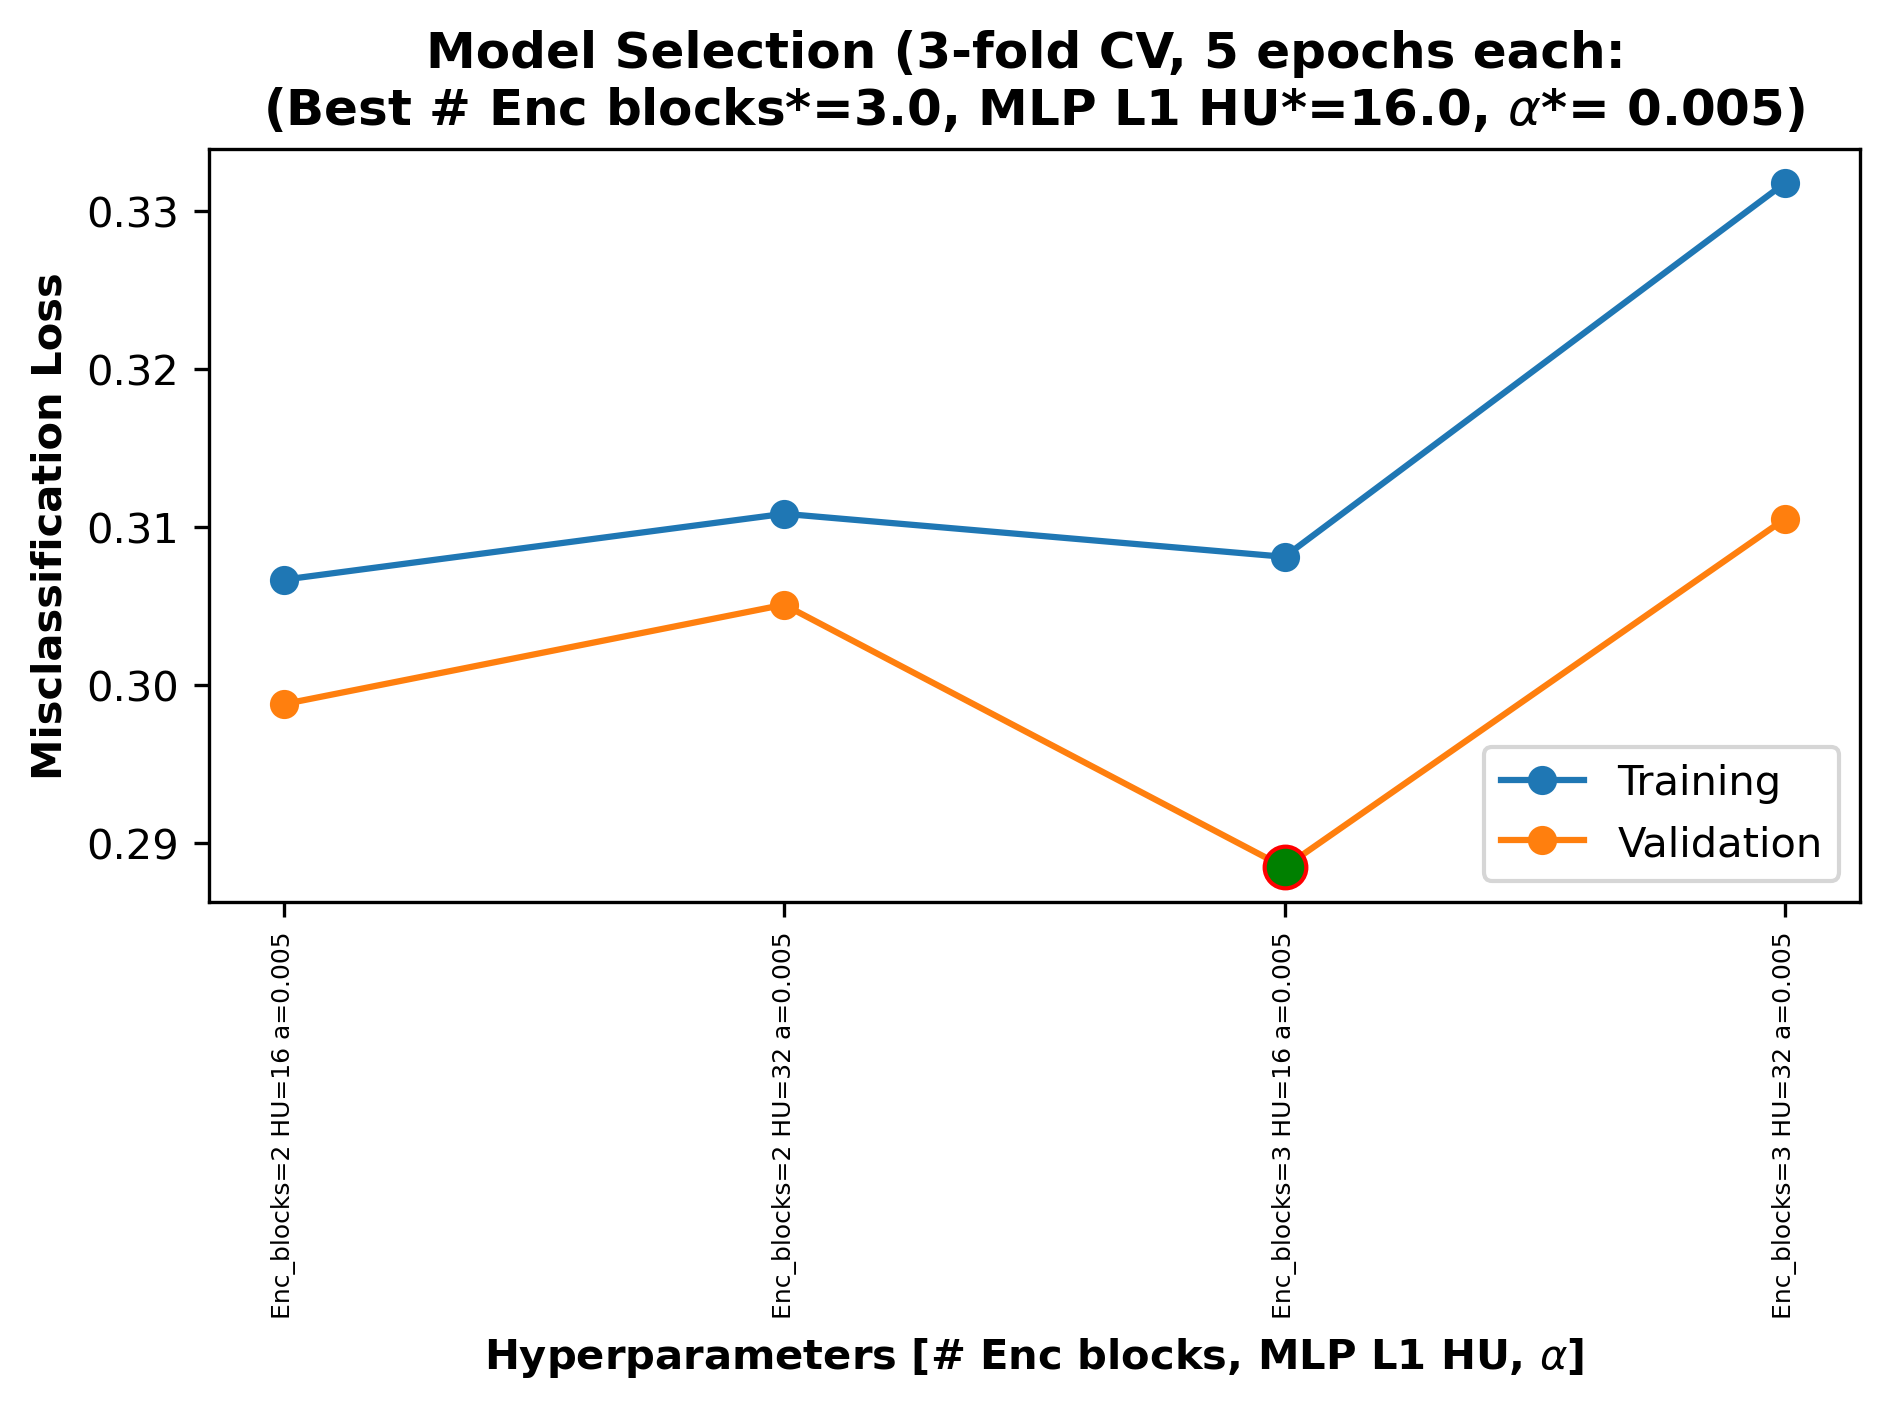

In [5]:
classifier.plotHistory()

**Step-4:** Training the best model on the entire training set and evaluating on the test set.

Training on the best model parameters:
# Enc blocks = 3, MLP L1 HU = 16, alpha=0.005


Train:  20%|██████████████▌                                                          | 1/5 [22:34<1:30:19, 1354.86s/it]

Proxy Test loss: 1.98
Misclassification Test Loss: 0.52
Epoch 1/5 Proxy Train loss: 2.13
Epoch 1/5 Misclassification Train loss: 0.68


Train:  40%|█████████████████████████████▏                                           | 2/5 [45:46<1:08:49, 1376.42s/it]

Proxy Test loss: 1.88
Misclassification Test Loss: 0.42
Epoch 2/5 Proxy Train loss: 1.92
Epoch 2/5 Misclassification Train loss: 0.46


Train:  60%|███████████████████████████████████████████▊                             | 3/5 [1:11:13<48:10, 1445.03s/it]

Proxy Test loss: 1.80
Misclassification Test Loss: 0.34
Epoch 3/5 Proxy Train loss: 1.85
Epoch 3/5 Misclassification Train loss: 0.39


Train:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [1:36:18<24:28, 1468.69s/it]

Proxy Test loss: 1.75
Misclassification Test Loss: 0.29
Epoch 4/5 Proxy Train loss: 1.79
Epoch 4/5 Misclassification Train loss: 0.33


Train: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [1:59:31<00:00, 1434.21s/it]


Proxy Test loss: 1.73
Misclassification Test Loss: 0.27
Epoch 5/5 Proxy Train loss: 1.75
Epoch 5/5 Misclassification Train loss: 0.29


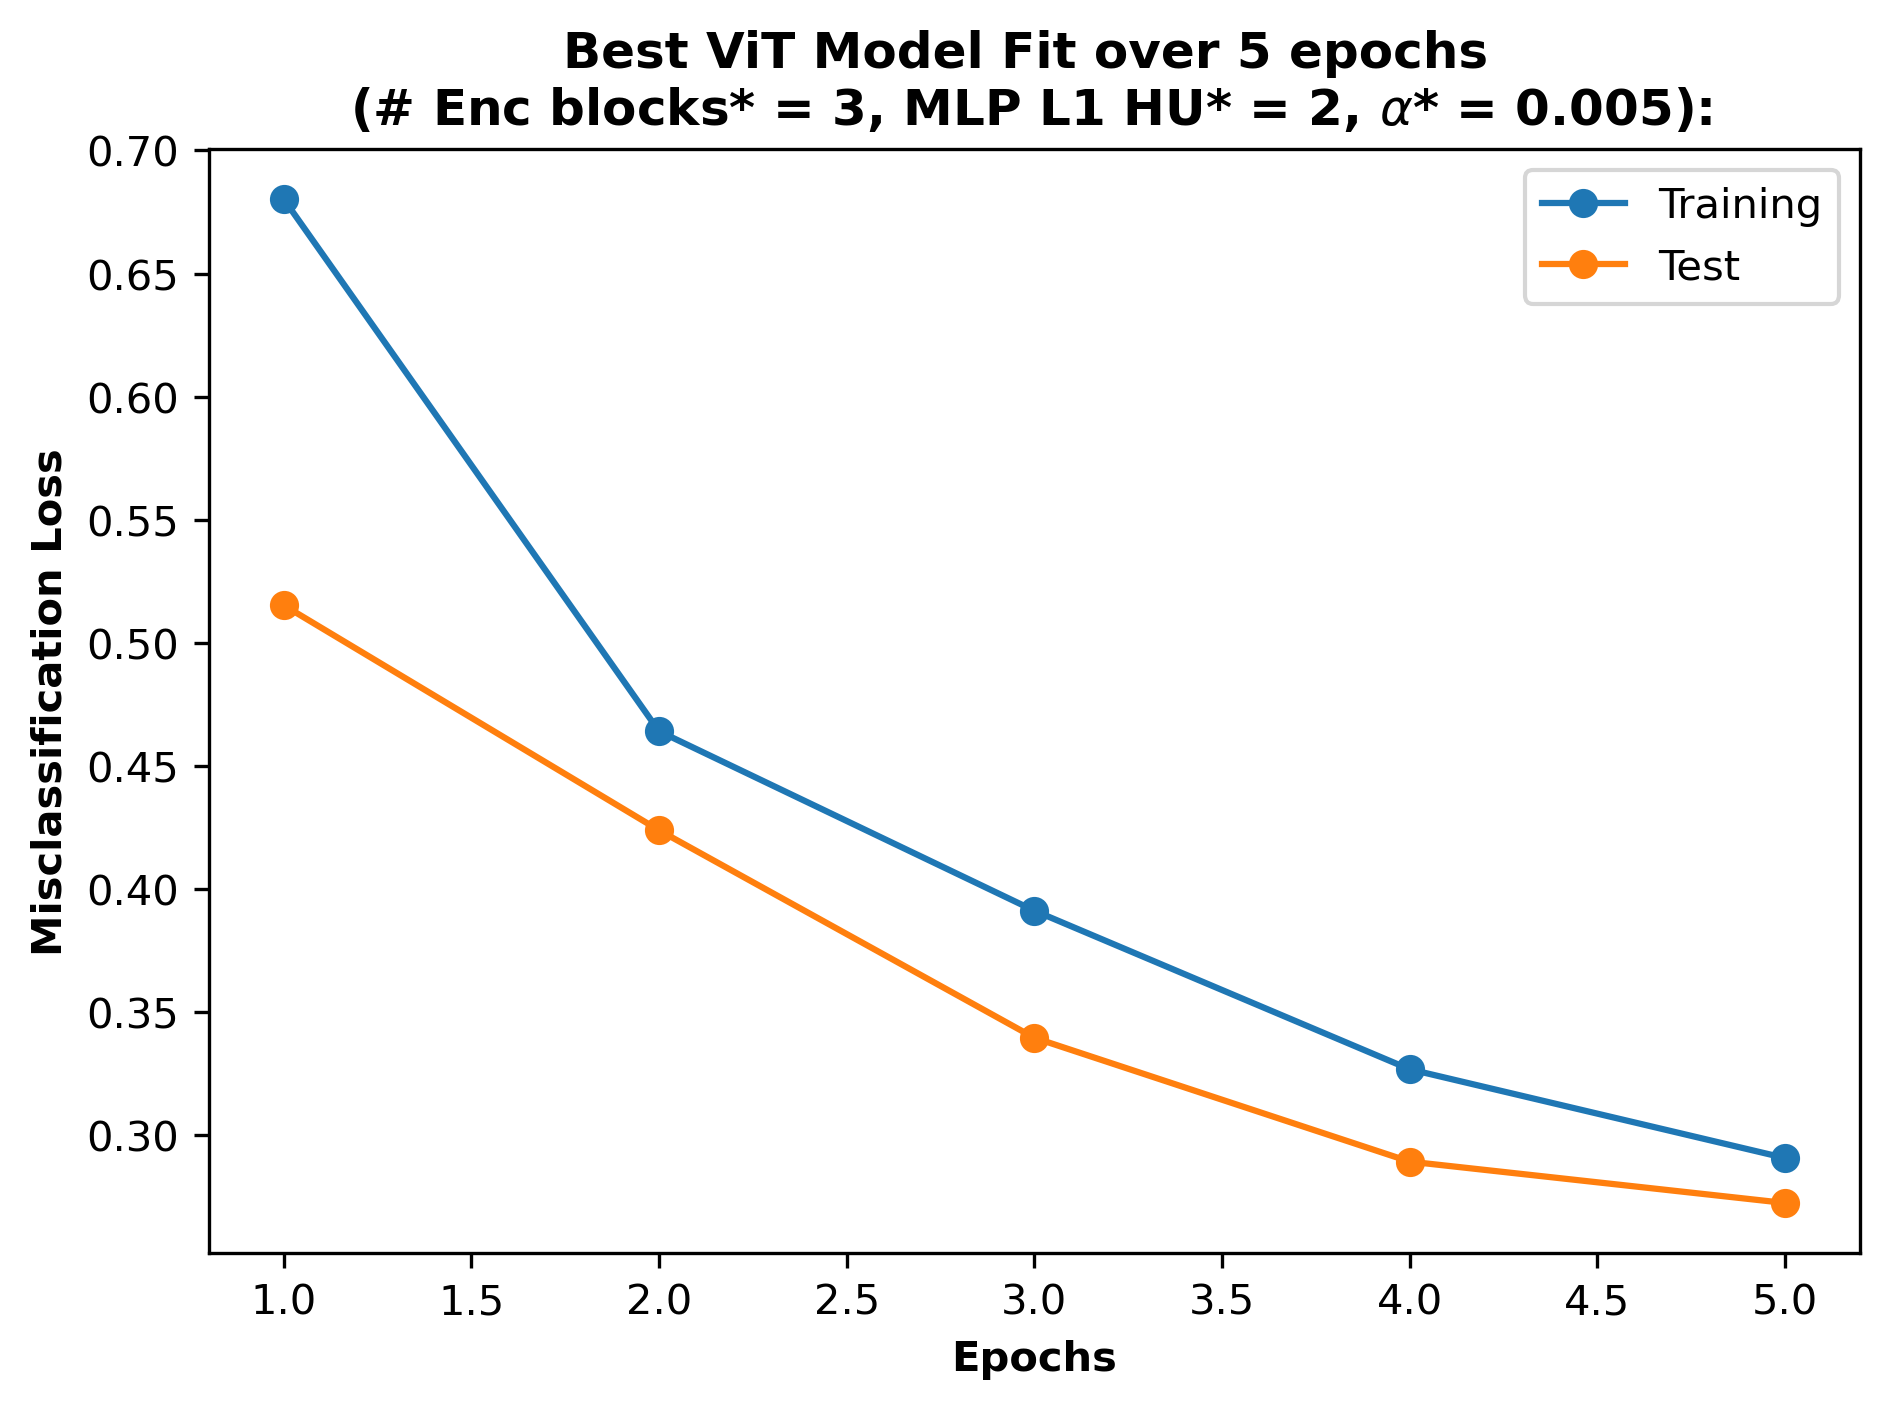

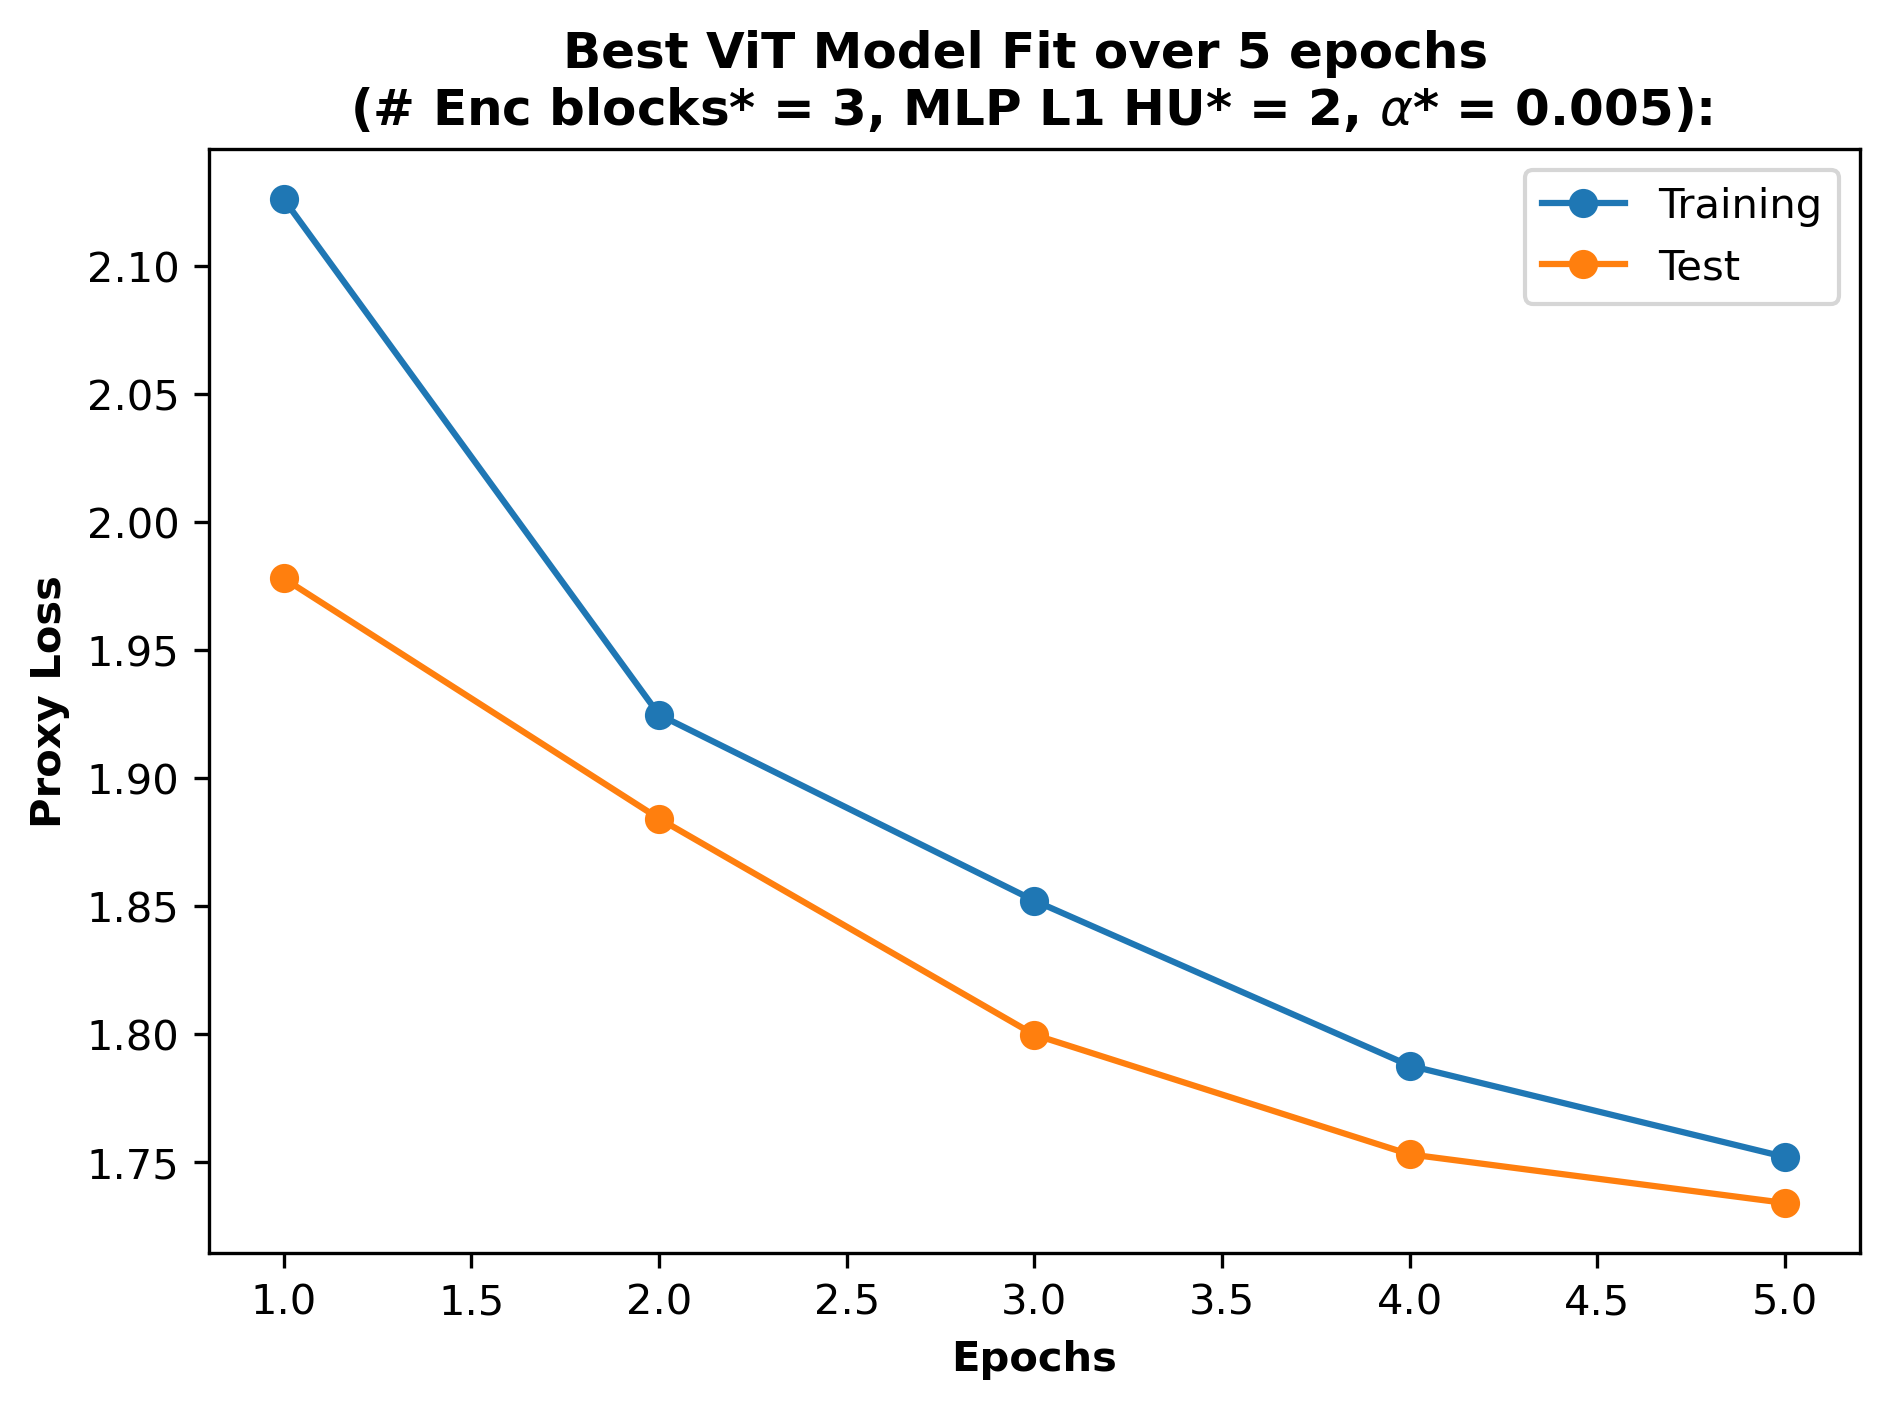

In [6]:
classifier.evaluate()

## Observations & Conclusion

1. As per the model selection exercise performed using 3-fold cross validation across the four different model configurations for the ViT based Handwritten Digit Recognition task, the following model performed the best:

| Encoder Blocks | # Hidden Units (MLP 1st Layer)|
|:------:|:-------------:|
|3|16|


2. From the model selection plot, it is observed that 3 Encoder block with 16 hidden units (MLP 1st Layer) performs best with a good trade off between bias and varaince during training and cross validation stages. The inference we can make here is that deeper networks and larger number of hidden units don’t necessarily lead to better performing networks. This goes against the traditional saying, *"The more, the merrier"*. On the other hand, with too less parameters/lower model complexity, it may underfit with very high bias leading to declining accuracy.


3. The training and test losses obtained using the best model have also been plotted as a function of the number of training epochs, which shows a declining trend in the losses and therefore an improvement in the overall accuracy on unseen test data.


4. The training and test results of the best model, after 5 epochs, are summarized below:

|Mode|Proxy Loss| Misclassification Loss|
|:-------|:----:|:------------------:|
|**Training**|1.75|0.29 (71% accuracy)|
|**Testing**|1.73|0.27 (73% accuracy)|


**NOTE:**

- The original set of hyperparameters chosen for the model selection activity included the following:

|Hyperparameters|Range|
|:---------------|:----------|
|**Learning Rates**| [0.001, 0.003, 0.01, 0.03] |
|**# Encoder Blocks** | [1, 2, 3] |
|**# Hidden Layers (MLP)**| [1, 2] |
|**# Hidden Units/Layer (MLP 1st Layer)**|[16, 32]|

- However, due to long hours of computational time required for training these 12 model configurations coupled with 3-cross fold validation for each configuration, totalling upto 12x3= 24 models each with 5 training epochs, our exploration on model selection was limited to 4 models.

# Related Works

Applying self-attention to images in the traditional sense would require that each pixel attends to every other pixel. With quadratic cost in the number of pixels, this does not scale to realistic input sizes. Thus, to apply Transformers in the context of image processing, several approximations have been tried in the past:

- *Parmar et al. 2018* applied the self-attention only in local neighborhoods for each query pixel instead of globally. Such local multi-head dot-product self attention blocks can completely replace convolutions (*Hu et al. 2019*; *Ramachandran et al.*, 2019; *Zhao et al. 2020*).


- On a different note, *Sparse Transformers*, by *Child et al. 2019* employ scalable approximations to global self-attention in order to be applicable to images. An alternative way to scale attention is to apply it in blocks of varying sizes (*Weissenborn et al. 2019*), in the extreme case only along individual axes (*Ho et al. 2019*; *Wang et al. 2020a*). Many of these specialized attention architectures demonstrate promising results on computer vision tasks, but require complex engineering to be implemented efficiently on hardware accelerators.


- The works of *Cordonnier et al. (2020)* involves extracting patches of size 2x2 from the input image and apply full self-attention on top. This model is similar to ViT (*Dosovitskiy et al. 2020*), but the latter goes further to demonstrate that large scale pre-training makes vanilla transformers competitive with (or even better than) state-of-the-art CNNs. Moreover, *Cordonnier et al. 2020* use a small patch size of 2x2 pixels, which makes the model applicable only to small-resolution images, while *Dosovitskiy et al. 2020* handles medium-resolution images as well.


- The idea of combining convolutional neural networks with forms of self-attention has been gaining some popularity too, e.g. by augmenting feature maps for image classification (*Bello et al. 2019*) or by further processing the output of a CNN using self-attention, e.g. for object detection (*Hu et al. 2018*; *Carion et al. 2020*), video processing (*Wang et al. 2018*; *Sun et al. 2019*), image classification (*Wu et al. 2020*), unsupervised object discovery (*Locatello et al. 2020*), or unified text-vision tasks (*Chen et al. 2020c*; *Lu et al. 2019*; *Li et al. 2019*).


- Another interesting set of work is the image GPT (iGPT) (*Chen et al. 2020a*), which applies Transformers to image pixels after reducing image resolution and color space. The model is trained in an unsupervised fashion as a generative model, and the resulting representation can then be fine-tuned or probed linearly for classification performance, achieving a maximal accuracy of 72% on ImageNet.

# References:

1. Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., Dehghani, M., Minderer, M., Heigold, G., Gelly, S., Uszkoreit, J., & Houlsby, N. (2020). An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale. https://arxiv.org/abs/2010.11929


2. Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., Kaiser, L., & Polosukhin, I. (2017). Attention Is All You Need. https://arxiv.org/abs/1706.03762